# Feature Store Example (Stocks)

This notebook demonstrates the following:
- Generate features and feature-sets
- Build complex transformations and ingest to offline and real-time data stores
- Fetch feature vectors for training
- Save feature vectors for re-use in real-time pipelines
- Access features and their statistics in real-time

Install the latest MLRun package and the following package before running the demo and restart the notebook

    !pip uninstall storey

Setting up the environment and project

In [ ]:
import mlrun
mlrun.set_environment(project="stocks")

## Create Sample Data For Demo

In [2]:
import pandas as pd
quotes = pd.DataFrame(
    {
        "time": [
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.030"),
            pd.Timestamp("2016-05-25 13:30:00.041"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.049"),
            pd.Timestamp("2016-05-25 13:30:00.072"),
            pd.Timestamp("2016-05-25 13:30:00.075")
        ],
        "ticker": [
               "GOOG",
               "MSFT",
               "MSFT",
               "MSFT",
               "GOOG",
               "AAPL",
               "GOOG",
               "MSFT"
           ],
           "bid": [720.50, 51.95, 51.97, 51.99, 720.50, 97.99, 720.50, 52.01],
           "ask": [720.93, 51.96, 51.98, 52.00, 720.93, 98.01, 720.88, 52.03]
    }
)

trades = pd.DataFrame(
       {
           "time": [
               pd.Timestamp("2016-05-25 13:30:00.023"),
               pd.Timestamp("2016-05-25 13:30:00.038"),
               pd.Timestamp("2016-05-25 13:30:00.048"),
               pd.Timestamp("2016-05-25 13:30:00.048"),
               pd.Timestamp("2016-05-25 13:30:00.048")
           ],
           "ticker": ["MSFT", "MSFT", "GOOG", "GOOG", "AAPL"],
           "price": [51.95, 51.95, 720.77, 720.92, 98.0],
           "quantity": [75, 155, 100, 100, 100]
       }
)


stocks = pd.DataFrame(
       {
           "ticker": ["MSFT", "GOOG", "AAPL"],
           "name": ["Microsoft Corporation", "Alphabet Inc", "Apple Inc"],
           "exchange": ["NASDAQ", "NASDAQ", "NASDAQ"]
       }
)

import datetime
def move_date(df, col):
    max_date = df[col].max()
    now_date = datetime.datetime.now()
    delta = now_date - max_date 
    df[col] = df[col] + delta 
    return df

quotes = move_date(quotes, "time")
trades = move_date(trades, "time")

### View Demo Data

In [3]:
quotes

,time,ticker,bid,ask
0,2021-01-31 23:47:38.524117,GOOG,720.50,720.93
1,2021-01-31 23:47:38.524117,MSFT,51.95,51.96
2,2021-01-31 23:47:38.531117,MSFT,51.97,51.98
3,2021-01-31 23:47:38.542117,MSFT,51.99,52.00
4,2021-01-31 23:47:38.549117,GOOG,720.50,720.93
5,2021-01-31 23:47:38.550117,AAPL,97.99,98.01
6,2021-01-31 23:47:38.573117,GOOG,720.50,720.88
7,2021-01-31 23:47:38.576117,MSFT,52.01,52.03


In [4]:
trades

,time,ticker,price,quantity
0,2021-01-31 23:47:38.552094,MSFT,51.95,75
1,2021-01-31 23:47:38.567094,MSFT,51.95,155
2,2021-01-31 23:47:38.577094,GOOG,720.77,100
3,2021-01-31 23:47:38.577094,GOOG,720.92,100
4,2021-01-31 23:47:38.577094,AAPL,98.00,100


In [5]:
stocks

,ticker,name,exchange
0,MSFT,Microsoft Corporation,NASDAQ
1,GOOG,Alphabet Inc,NASDAQ
2,AAPL,Apple Inc,NASDAQ


## Define, Infer and Ingest Feature Sets

In [7]:
import mlrun.feature_store as fs
from mlrun.feature_store.steps import *
from mlrun.features import MinMaxValidator

> 2021-01-31 23:56:00,434 [warning] Failed resolving version info. Ignoring and using defaults
> 2021-01-31 23:56:02,504 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': 'unstable', 'client_version': 'unstable'}


### Build & Ingest Simple Feature Set (stocks)

In [8]:
# add feature set without time column (stock ticker metadata) 
stocks_set = fs.FeatureSet("stocks", entities=[fs.Entity("ticker")])
fs.ingest(stocks_set, stocks, infer_options=fs.InferOptions.default())

,name,exchange
ticker,,
MSFT,Microsoft Corporation,NASDAQ
GOOG,Alphabet Inc,NASDAQ
AAPL,Apple Inc,NASDAQ


### Build Advanced feature set - with feature engineering pipeline
Define a feature set with custom data processing and time aggregation functions 

In [9]:
# create a new feature set
quotes_set = fs.FeatureSet("stock-quotes", entities=[fs.Entity("ticker")])

**define a custom pipeline step (python class)**

In [10]:
class MyMap(MapClass):
    def __init__(self, multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self._multiplier = multiplier

    def do(self, event):
        event["multi"] = event["bid"] * self._multiplier
        return event

**build and show the transformatiom pipeline**

Use `storey` stream processing classes along with library and custom classes

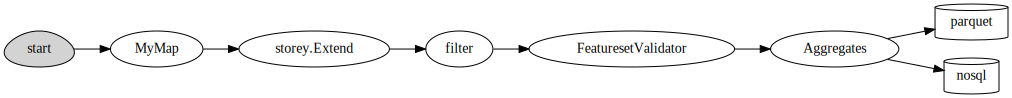

In [11]:
quotes_set.graph.to("MyMap", multiplier=3)\
                .to("storey.Extend", _fn="({'extra': event['bid'] * 77})")\
                .to("storey.Filter", "filter", _fn="(event['bid'] > 51.92)")\
                .to(FeaturesetValidator())

quotes_set.add_aggregation("asks", "ask", ["sum", "max"], ["1h", "5h"], "10m")
quotes_set.add_aggregation("bids", "bid", ["min", "max"], ["1h"], "10m")

# add feature validation policy
quotes_set["bid"] = fs.Feature(validator=MinMaxValidator(min=52, severity="info"))

# add default target definitions and plot
quotes_set.set_targets()
quotes_set.plot(rankdir="LR", with_targets=True)

**test and show the pipeline results locally (allow to quickly develop and debug)**

In [12]:
fs.infer_metadata(
    quotes_set,
    quotes,
    entity_columns=["ticker"],
    timestamp_key="time",
    options=fs.InferOptions.default(),
)

,asks_sum_1h,asks_sum_5h,asks_max_1h,asks_max_5h,bids_min_1h,bids_max_1h,time,bid,ask,multi,extra
ticker,,,,,,,,,,,
GOOG,720.93,720.93,720.93,720.93,720.50,720.50,2021-01-31 23:47:38.524117,720.50,720.93,2161.50,55478.50
MSFT,51.96,51.96,51.96,51.96,51.95,51.95,2021-01-31 23:47:38.524117,51.95,51.96,155.85,4000.15
MSFT,103.94,103.94,51.98,51.98,51.95,51.97,2021-01-31 23:47:38.531117,51.97,51.98,155.91,4001.69
MSFT,155.94,155.94,52.00,52.00,51.95,51.99,2021-01-31 23:47:38.542117,51.99,52.00,155.97,4003.23
GOOG,1441.86,1441.86,720.93,720.93,720.50,720.50,2021-01-31 23:47:38.549117,720.50,720.93,2161.50,55478.50
AAPL,98.01,98.01,98.01,98.01,97.99,97.99,2021-01-31 23:47:38.550117,97.99,98.01,293.97,7545.23
GOOG,2162.74,2162.74,720.93,720.93,720.50,720.50,2021-01-31 23:47:38.573117,720.50,720.88,2161.50,55478.50
MSFT,207.97,207.97,52.03,52.03,51.95,52.01,2021-01-31 23:47:38.576117,52.01,52.03,156.03,4004.77


In [13]:
# print the feature set object
print(quotes_set.to_yaml())

kind: FeatureSet
metadata:
  name: stock-quotes
spec:
  entities:
  - name: ticker
    value_type: str
  features:
  - name: asks_sum_1h
    value_type: float
  - name: asks_sum_5h
    value_type: float
  - name: asks_max_1h
    value_type: float
  - name: asks_max_5h
    value_type: float
  - name: bids_min_1h
    value_type: float
  - name: bids_max_1h
    value_type: float
  - name: bid
    value_type: float
  - name: ask
    value_type: float
  - name: multi
    value_type: float
  - name: extra
    value_type: float
  partition_keys: []
  timestamp_key: time
  targets:
  - name: parquet
    kind: parquet
  - name: nosql
    kind: nosql
  graph:
    states:
      MyMap:
        kind: task
        class_name: MyMap
        class_args:
          multiplier: 3
      storey.Extend:
        kind: task
        class_name: storey.Extend
        class_args:
          _fn: '({''extra'': event[''bid''] * 77})'
        after:
        - MyMap
      filter:
        kind: task
        class_name

### ingest data into offline and online stores
This will write to both targets (Parquet and NoSQL)

In [14]:
# save ingest data and print the FeatureSet spec
df = fs.ingest(quotes_set, quotes)

## Get an Offline Feature Vector for Training
Example of combining features from 3 sources with time travel join of 3 tabels with **time travel**

Specify a set of features and request the feature vector offline result as a dataframe

In [15]:
features = [
    "stock-quotes.multi",
    "stock-quotes.asks_sum_5h as total_ask",
    "stock-quotes.bids_min_1h",
    "stock-quotes.bids_max_1h",
    "stocks.*",
]

resp = fs.get_offline_features(features, entity_rows=trades, entity_timestamp_column="time")
resp.to_dataframe()

,time,ticker,price,quantity,multi,total_ask,bids_min_1h,bids_max_1h,name,exchange
0,2021-01-31 23:47:38.552094,MSFT,51.95,75,155.97,987.82,51.95,51.99,Microsoft Corporation,NASDAQ
1,2021-01-31 23:47:38.567094,MSFT,51.95,155,155.97,987.82,51.95,51.99,Microsoft Corporation,NASDAQ
2,2021-01-31 23:47:38.577094,GOOG,720.77,100,2161.50,10813.70,720.50,720.50,Alphabet Inc,NASDAQ
3,2021-01-31 23:47:38.577094,GOOG,720.92,100,2161.50,10813.70,720.50,720.50,Alphabet Inc,NASDAQ
4,2021-01-31 23:47:38.577094,AAPL,98.00,100,293.97,490.05,97.99,97.99,Apple Inc,NASDAQ


In [16]:
vector = fs.FeatureVector("stocks-vec", features, description="stocks demo feature vector")
vector.save()

## Initialize an online feature service and use it for real-time inference

In [17]:
service = fs.get_online_feature_service("stocks-vec")

**Request feature vector statistics, can be used for imputing or validation**

In [18]:
service.vector.get_stats_table()

,count,mean,min,max,std,hist,unique,top,freq
multi,8.0,925.27875,155.85,2161.50,1024.751408,"[[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
total_ask,8.0,617.91875,51.96,2162.74,784.877980,"[[4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,...",NaN,NaN,NaN
bids_min_1h,8.0,308.41125,51.95,720.50,341.596673,"[[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
bids_max_1h,8.0,308.42625,51.95,720.50,341.583803,"[[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,NaN,NaN
name,3.0,NaN,NaN,NaN,NaN,NaN,3.0,Microsoft Corporation,1.0
exchange,3.0,NaN,NaN,NaN,NaN,NaN,1.0,NASDAQ,3.0


**Real-time feature vector request**

In [19]:
service.get([{"ticker": "GOOG"}, {"ticker": "MSFT"}])

[{'asks_sum_5h': 10813.699999999999,
  'bids_min_1h': 720.5,
  'bids_max_1h': 720.5,
  'ticker': 'GOOG',
  'multi': 2161.5,
  'name': 'Alphabet Inc',
  'exchange': 'NASDAQ'},
 {'asks_sum_5h': 1039.85,
  'bids_min_1h': 51.95,
  'bids_max_1h': 52.01,
  'ticker': 'MSFT',
  'multi': 156.03,
  'name': 'Microsoft Corporation',
  'exchange': 'NASDAQ'}]

In [20]:
service.get([{"ticker": "AAPL"}])

[{'asks_sum_5h': 490.05,
  'bids_min_1h': 97.99,
  'bids_max_1h': 97.99,
  'ticker': 'AAPL',
  'multi': 293.97,
  'name': 'Apple Inc',
  'exchange': 'NASDAQ'}]

In [41]:
service.close()